# Data exploration

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nlp_module import normalize_corpus, remove_stopwords
from wordcloud import WordCloud, STOPWORDS

In [2]:
data = pd.read_csv("datasets\combined_csv.csv",
                   dtype="object",
                   low_memory=False)
data.head(1)

,Id,AcceptedAnswerId,CreationDate,Score,ViewCount,Body,OwnerUserId,Title,Tags,AnswerCount,CommentCount
0,415160,NaN,2009-01-06 02:00:17,7,6374,<p>What is the best method for creating an <a ...,51886.0,Best method of Instantiating an XMLHttpRequest...,<javascript><ajax><cross-browser><xmlhttprequest>,9,1


In [3]:
data.shape

(2568165, 11)

Data exploration will be divided in two parts. 

The first part is about numeric data. In this step, we will cleaning numerical data as comment, view and answer counter and score. These features will help us to select the most confidence posts.

The second part is about text data. Textual data are unstructured data that need a specific processing. We will create a dataset with only textual data. In this dataset, we will performn all stage that are necessary to cleaning data. Textual data need to be transformed on numeric data before to use it in Machine Learning algorithms. Thus, we will use numerous functions. These functions will be remove HTML tags around title and body text ; removed accentued characters (if needed) ; expanded contractions forms (typically found in English language) ; removed special characters, lemmatized text and remove stopwords. 

## I - Numeric data processing

### 1) Dealing with missing values and duplicated data

In [4]:
print((data.isnull().mean()\
       *100).round(2))

Id                   0.00
AcceptedAnswerId    43.42
CreationDate         0.00
Score                0.00
ViewCount            0.00
Body                 0.00
OwnerUserId          2.20
Title                0.00
Tags                 0.00
AnswerCount          0.00
CommentCount         0.00
dtype: float64


In [5]:
data.drop_duplicates(subset="Id", 
                     inplace=True)

In [6]:
data["CreationDate"] = pd.to_datetime(data["CreationDate"],
                                     format="%Y-%m-%d", 
                                     errors="ignore")
data["Score"] = data["Score"].astype("int32")
data["ViewCount"] = data["ViewCount"].astype("int32")
data["AnswerCount"] = data["AnswerCount"].astype("int32")
data["CommentCount"] = data["CommentCount"].astype("int32")

### 2) Determine characterics of a good question

First, we consider that posts without "AcceptedAnswerId" are bad posts. We delete these posts of our sample. 

In [7]:
data.dropna(subset=["AcceptedAnswerId"],
            inplace=True)
data.shape

(1438314, 11)

In [8]:
data.describe()

,Score,ViewCount,AnswerCount,CommentCount
count,1.438314e+06,1.438314e+06,1.438314e+06,1.438314e+06
mean,3.656626e+00,3.860701e+03,1.907445e+00,3.200809e+00
std,5.173774e+01,3.892935e+04,1.844153e+00,2.682042e+00
min,-2.500000e+01,5.000000e+00,1.000000e+00,1.000000e+00
25%,0.000000e+00,5.800000e+01,1.000000e+00,1.000000e+00
50%,0.000000e+00,1.680000e+02,1.000000e+00,2.000000e+00
75%,2.000000e+00,9.220000e+02,2.000000e+00,4.000000e+00
max,2.577800e+04,9.830871e+06,1.290000e+02,6.800000e+01


As we can see, some posts have only one answer or one comment. We make choice to keep only posts with two comments or more. We made the same with the "AnswerCount". 

In [9]:
data = data.loc[data["CommentCount"] >= 2]
data = data.loc[data["AnswerCount"] >= 2]
data = data.loc[data["Score"] >= 2]
data.shape

(164598, 11)

In [10]:
data.describe()

,Score,ViewCount,AnswerCount,CommentCount
count,164598.000000,1.645980e+05,164598.000000,164598.000000
mean,20.880059,1.998435e+04,3.948456,4.139115
std,142.902179,1.014772e+05,3.664750,2.870641
min,2.000000,1.600000e+01,2.000000,2.000000
25%,2.000000,4.430000e+02,2.000000,2.000000
50%,4.000000,2.317000e+03,3.000000,3.000000
75%,9.000000,9.310750e+03,4.000000,5.000000
max,25778.000000,9.830871e+06,129.000000,62.000000


### 3) Univariate analysis

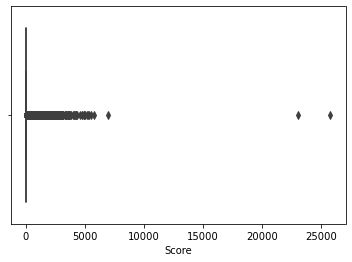

In [11]:
sns.boxplot(x="Score",
            data=data)
plt.show()

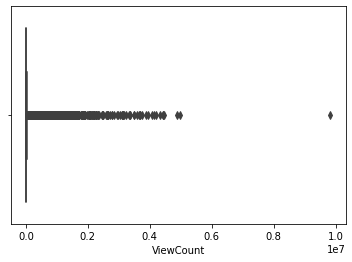

In [12]:
sns.boxplot(x="ViewCount",
            data=data)
plt.show()

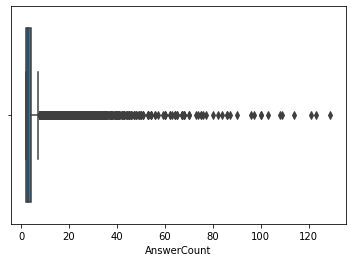

In [13]:
sns.boxplot(x="AnswerCount",
            data=data)
plt.show()

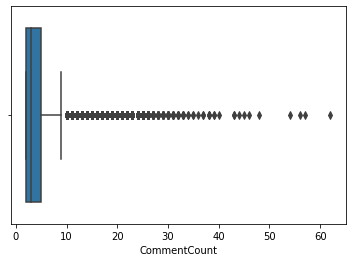

In [14]:
sns.boxplot(x="CommentCount",
            data=data)
plt.show()

### 4) Bivariate analysis

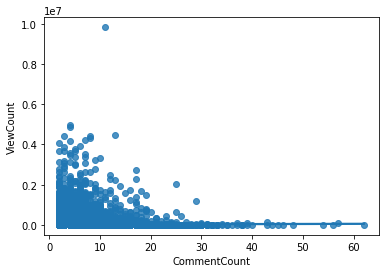

In [15]:
sns.regplot(x="CommentCount",
            y="ViewCount",
            data=data)
plt.show()

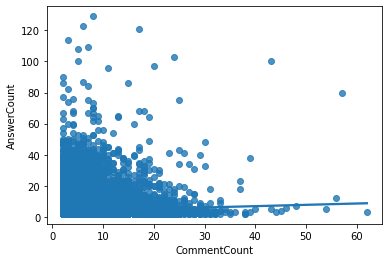

In [16]:
sns.regplot(x="CommentCount",
            y="AnswerCount",
            data=data)
plt.show()

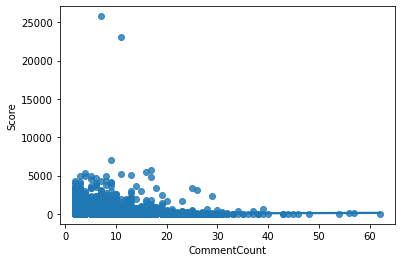

In [17]:
sns.regplot(x="CommentCount",
            y="Score",
            data=data)
plt.show()

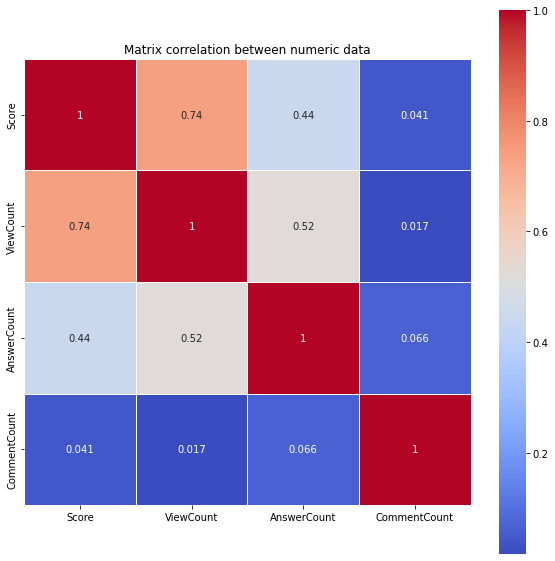

In [18]:
corr = data.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr, 
            cmap="coolwarm",
            annot=True,
            square=True,
            fmt=".2g",
            linewidths=.5)
plt.title("Matrix correlation between numeric data")
plt.show()

## II - Textual data

### 1) Processing text data

In [19]:
data_posts = pd.DataFrame()
data_posts["Id"] = data["Id"]
data_posts["Title"] = normalize_corpus(data["Title"])

In [20]:
data_posts["Body"] = normalize_corpus(data["Body"])

In [21]:
data_posts["Tags"] = data["Tags"]

In [22]:
data_posts.head(3)

,Id,Title,Body,Tags
6,415192,good way create simple python web service,I use python year I little experience python w...,<python><web-services>
10,415344,log implementation prefer,I implement log class c try decide I curious k...,<debugging><language-agnostic><logging>
16,414981,directly modify list element,I struct struct map public int size public map...,<c#><.net>


In [23]:
data_posts.to_csv("datasets/posts_clean.csv",
                  index=False)

In [24]:
del data
del data_posts

### 2) Descriptive analysis

In [25]:
posts = pd.read_csv("datasets/posts_clean.csv")
posts.head()

,Id,Title,Body,Tags
0,415192,good way create simple python web service,I use python year I little experience python w...,<python><web-services>
1,415344,log implementation prefer,I implement log class c try decide I curious k...,<debugging><language-agnostic><logging>
2,414981,directly modify list element,I struct struct map public int size public map...,<c#><.net>
3,415580,regex name group java,understanding java regex package not support n...,<java><regex>
4,415753,instance cache objective c,I want cache instance certain class class keep...,<objective-c><weak-references>


In [26]:
posts["Body"] = posts["Body"].str.lower()
posts["Body"] = posts["Body"].apply(remove_stopwords)

In [27]:
posts["Tags"]= posts["Tags"].replace({"<": " "}, regex=True)
posts["Tags"] = posts["Tags"].replace({">": " "}, regex=True)

In [28]:
posts.head()

,Id,Title,Body,Tags
0,415192,good way create simple python web service,use python year little experience python web p...,python web-services
1,415344,log implementation prefer,implement log class c try decide curious know ...,debugging language-agnostic logging
2,414981,directly modify list element,struct struct map public int size public map i...,c# .net
3,415580,regex name group java,understanding java regex package not support n...,java regex
4,415753,instance cache objective c,want cache instance certain class class keep d...,objective-c weak-references


In [29]:
posts.isnull().mean()
posts.dropna(axis=0, inplace=True)

In [30]:
posts.shape

(164588, 4)

In [31]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

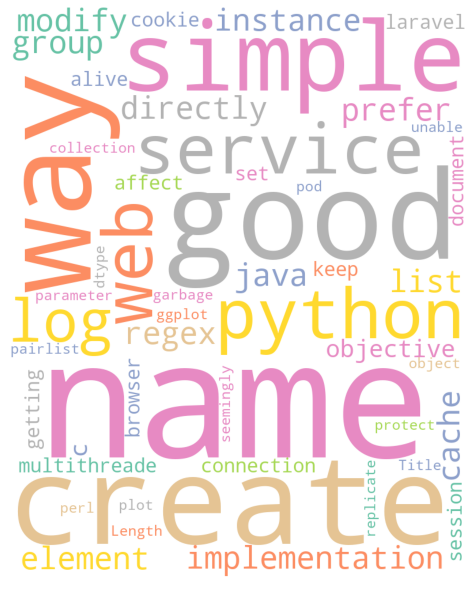

In [32]:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 800, height = 1000,
                max_words=1000,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 12,
                colormap="Set2").generate(str(posts["Title"]))
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [33]:
vectorizer = CountVectorizer(max_features=1000)
bow_title = vectorizer.fit_transform(posts["Title"]).toarray()
df_title = pd.DataFrame(bow_title, columns=vectorizer.get_feature_names())
df_title = pd.DataFrame(df_title.sum(), columns=["Value"])
df_title.head()

,Value
able,198
absolute,166
abstract,270
accept,241
access,1860


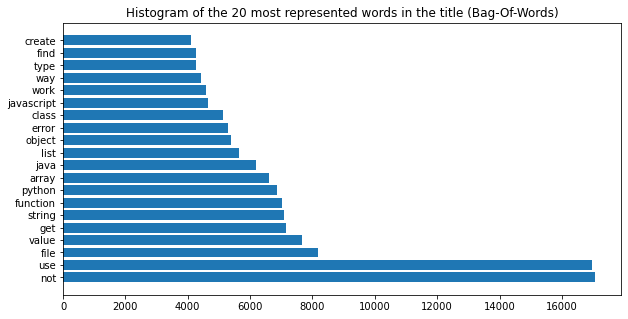

In [34]:
top_20_title_word = df_title.sort_values("Value", ascending=False)[:20]

plt.figure(figsize=(10,5))
plt.barh(y=top_20_title_word.index, width=top_20_title_word.Value)
plt.title("Histogram of the 20 most represented words in the title (Bag-Of-Words)")
plt.show()

In [35]:
vectorizer_tf = TfidfVectorizer(max_features=1000)
tfidf_title = vectorizer_tf.fit_transform(posts['Title']).toarray()
feature_names = vectorizer_tf.get_feature_names()
df_title_tf = pd.DataFrame(tfidf_title, columns=feature_names)
df_title_tf = pd.DataFrame(df_title_tf.sum(), columns=["Value"])

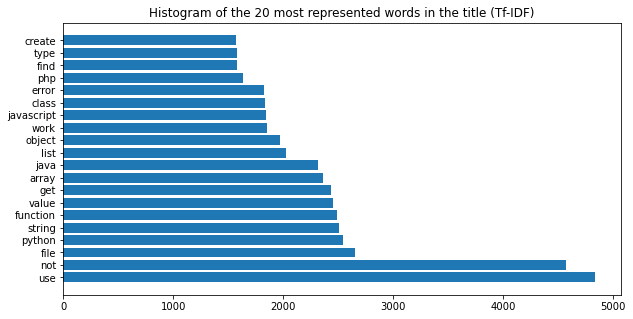

In [36]:
top_20_title_word_tf = df_title_tf.sort_values("Value",ascending=False)[:20]

plt.figure(figsize=(10,5))
plt.barh(y=top_20_title_word_tf.index, width=top_20_title_word_tf.Value)
plt.title("Histogram of the 20 most represented words in the title (Tf-IDF)")
plt.show()

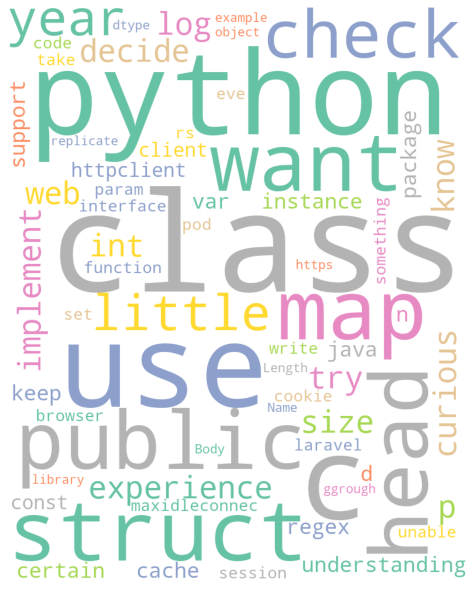

In [37]:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 800, height = 1000,
                max_words=1000,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 12,
                colormap="Set2").generate(str(posts["Body"]))
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [38]:
vectorizer = CountVectorizer(max_features=1000)
bow_body = vectorizer.fit_transform(posts["Body"]).toarray()
df_body = pd.DataFrame(bow_body, columns=vectorizer.get_feature_names())
df_body = pd.DataFrame(df_body.sum(), columns=["Value"])
df_body.head()

,Value
abc,3459
able,14700
abstract,2744
accept,4717
access,14146


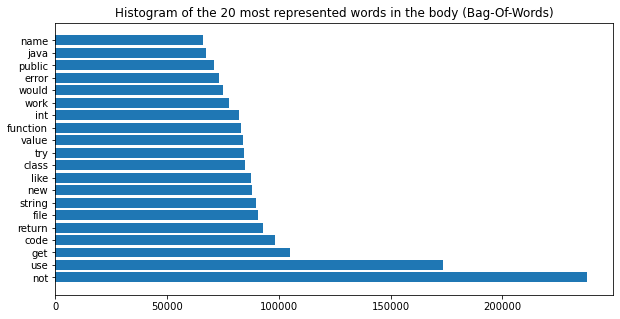

In [39]:
top_20_body_word = df_body.sort_values("Value", ascending=False)[:20]

plt.figure(figsize=(10,5))
plt.barh(y=top_20_body_word.index, width=top_20_body_word.Value)
plt.title("Histogram of the 20 most represented words in the body (Bag-Of-Words)")
plt.show()

In [40]:
vectorizer_tf = TfidfVectorizer(max_features=1000)
tfidf_body = vectorizer_tf.fit_transform(posts['Body']).toarray()
feature_names = vectorizer_tf.get_feature_names()
df_body_tf = pd.DataFrame(tfidf_body, columns=feature_names)
df_body_tf = pd.DataFrame(df_body_tf.sum(), columns=["Value"])

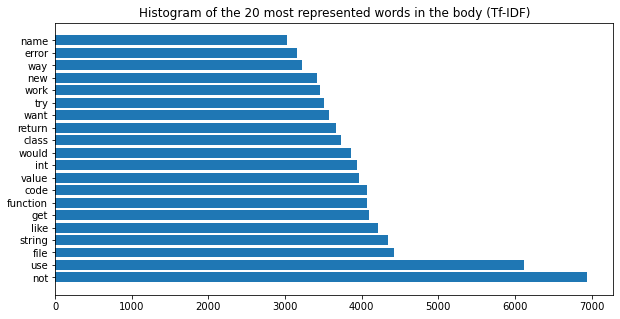

In [41]:
top_20_body_word_tf = df_body_tf.sort_values("Value",ascending=False)[:20]

plt.figure(figsize=(10,5))
plt.barh(y=top_20_body_word_tf.index, width=top_20_body_word_tf.Value)
plt.title("Histogram of the 20 most represented words in the body (Tf-IDF)")
plt.show()

In [42]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2,
            random_state=42)
body_tsne = tsne.fit_transform(tfidf_body)

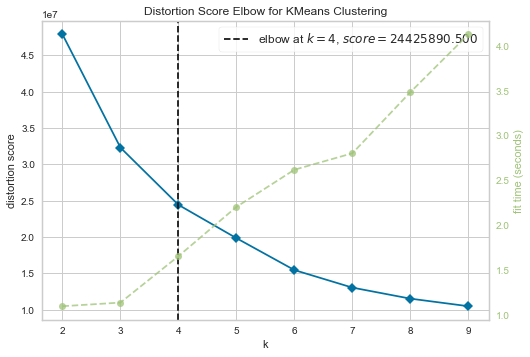

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [45]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

model = KMeans()
visualizer = KElbowVisualizer(model, k=(2, 10))

visualizer.fit(body_tsne)
visualizer.show()

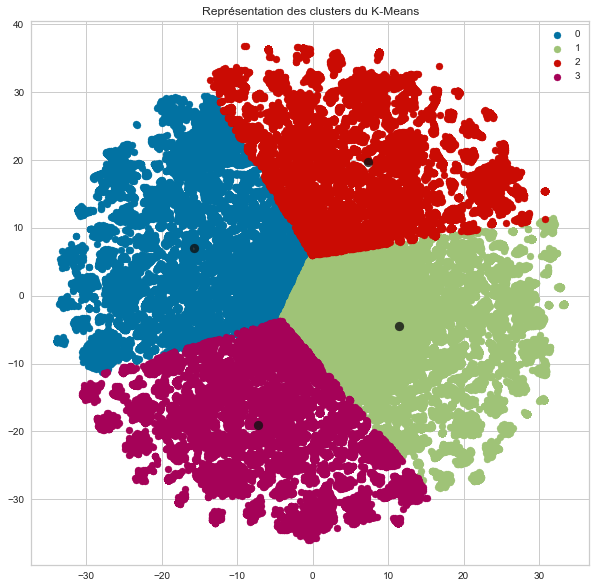

In [46]:
# Fitting KMeans
km = KMeans(n_clusters=4, 
            random_state=42)

# Prediction
label = km.fit_predict(body_tsne)
centroids = km.cluster_centers_
u_labels = np.unique(label)

# Graphical representation
plt.figure(figsize=(10, 10))
for i in u_labels:
    plt.scatter(body_tsne[label==i, 0], body_tsne[label==i, 1], label = i)
plt.scatter(centroids[:, 0], centroids[:,1], s=80, alpha=0.8, color='k')
plt.legend()
plt.title('Représentation des clusters du K-Means')
plt.show()

In [47]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2,
          random_state=42)

body_pca = pca.fit_transform(tfidf_body)

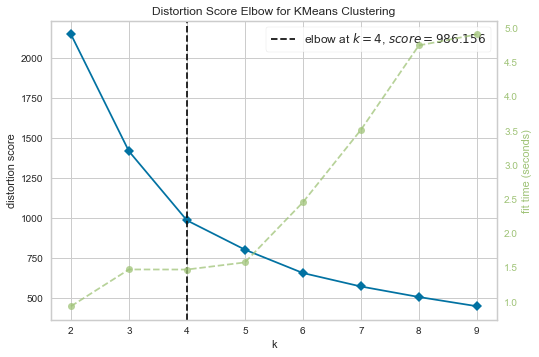

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [48]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2, 10))

visualizer.fit(body_pca)
visualizer.show()

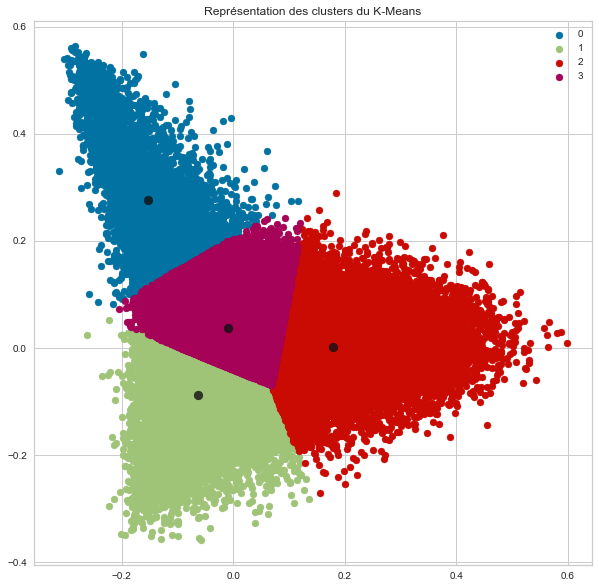

In [49]:
km = KMeans(n_clusters=4, 
            random_state=42)

# Prediction
label = km.fit_predict(body_pca)
centroids = km.cluster_centers_
u_labels = np.unique(label)

# Graphical representation
plt.figure(figsize=(10, 10))
for i in u_labels:
    plt.scatter(body_pca[label==i, 0], body_pca[label==i, 1], label = i)
plt.scatter(centroids[:, 0], centroids[:,1], s=80, alpha=0.8, color='k')
plt.legend()
plt.title('Représentation des clusters du K-Means')
plt.show()

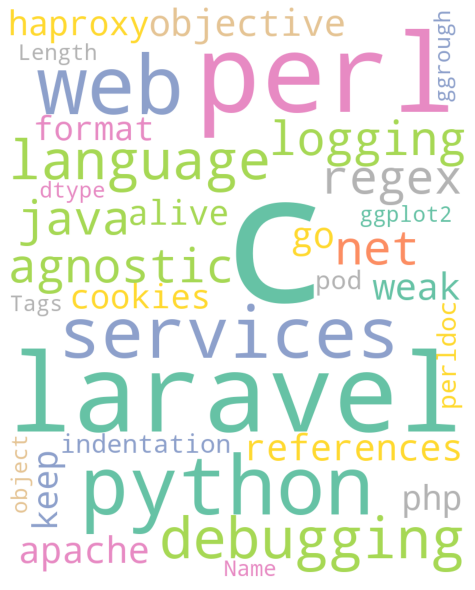

In [50]:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(width = 800, 
                height = 1000,
                background_color ='white',
                max_words = 1000, 
                stopwords = stopwords,
                min_font_size = 12,
                colormap="Set2"
                ).generate(str(posts["Tags"]))
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [51]:
vectorizer = CountVectorizer(max_features=1000)
bow_tags = vectorizer.fit_transform(posts["Tags"]).toarray()
df_tags = pd.DataFrame(bow_tags, columns=vectorizer.get_feature_names())
df_tags = pd.DataFrame(df_tags.sum(), columns=["Value"])

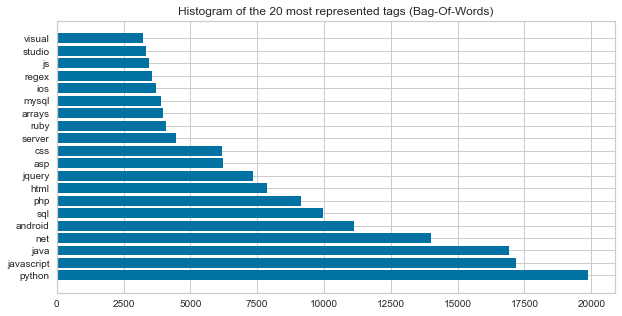

In [52]:
top_20_tags_word = df_tags.sort_values("Value", ascending=False)[:20]

plt.figure(figsize=(10,5))
plt.barh(y=top_20_tags_word.index, width=top_20_tags_word.Value)
plt.title("Histogram of the 20 most represented tags (Bag-Of-Words)")
plt.show()

In [53]:
vectorizer_tf = TfidfVectorizer(max_features=1000)
tfidf_tags = vectorizer_tf.fit_transform(posts['Tags']).toarray()
feature_names = vectorizer_tf.get_feature_names()
df_tags_tf = pd.DataFrame(tfidf_tags, columns=feature_names)
df_tags_tf = pd.DataFrame(df_tags_tf.sum(), columns=["Value"])

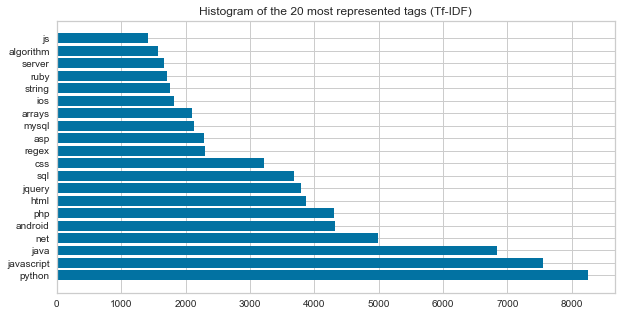

In [54]:
top_20_tags_word_tf = df_tags_tf.sort_values("Value",ascending=False)[:20]

plt.figure(figsize=(10,5))
plt.barh(y=top_20_tags_word_tf.index, width=top_20_tags_word_tf.Value)
plt.title("Histogram of the 20 most represented tags (Tf-IDF)")
plt.show()